## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 15,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 5,
  "N_FOLDS": 3,
  "BASE_MODEL_PATH": base_model_path + 'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 15,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 3,
 'BASE_MODEL_PATH': '/kaggle/input/efficientnet/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


## Auxiliary functions

In [6]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)


def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'], seed=SEED)
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'], seed=SEED)
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
    if p_rotate >= .8: # rotate 270
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)

    return image, label


def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 3e-05


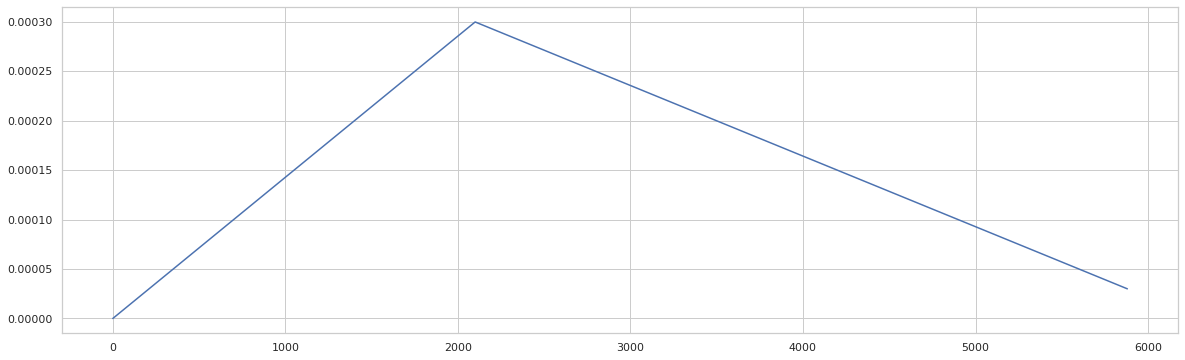

In [7]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [8]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=input_shape, 
                          weights='imagenet', 
                          include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [9]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es], 
                        class_weight={0: 1., 1: 20.},
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
44924928/44920640 [==============================] - 0s 0us/step
Epoch 1/15
323/323 - 100s - loss: 0.7801 - auc: 0.7447 - val_loss: 0.7968 - val_auc: 0.4232
Epoch 2/15
323/323 - 98s - loss: 0.6047 - auc: 0.8583 - val_loss: 0.3462 - val_auc: 0.4241
Epoch 3/15
323/323 - 98s - loss: 0.5946 - auc: 0.8676 - val_loss: 0.1884 - val_auc: 0.7938
Epoch 4/15
323/323 - 97s - loss: 0.5610 - auc: 0.8910 - val_loss: 0.4621 - val_auc: 0.8250
Epoch 5/15
323/323 - 98s - loss: 0.5395 - auc: 0.8946 - val_loss: 0.3214 - val_auc: 0.8599
Epoch 6/15
323/323 - 97s - loss: 0.5608 - auc: 0.8828 - val_loss: 0.2384 - val_auc: 0.8528
Epoch 7/15
323/323 - 97s - loss: 0.5263 - auc: 0.9046 - val_loss: 0.4127 - val_auc: 0.8555
Epoch 8/15
Restoring model weights from the end of the best epoch.
323/323 - 98s - loss: 0.5320 - auc: 0.9010 - val_loss: 0.2486 - val_auc: 0.8777
Epoch 00008: early stopping

FOLD: 2
Epoch 1/15
355/355 - 103s - loss: 0.9999 - auc: 0.6905 - val_loss: 0.7313 - val_auc: 0.6122
Epoch 2/15
3

## Model loss graph

Fold: 0


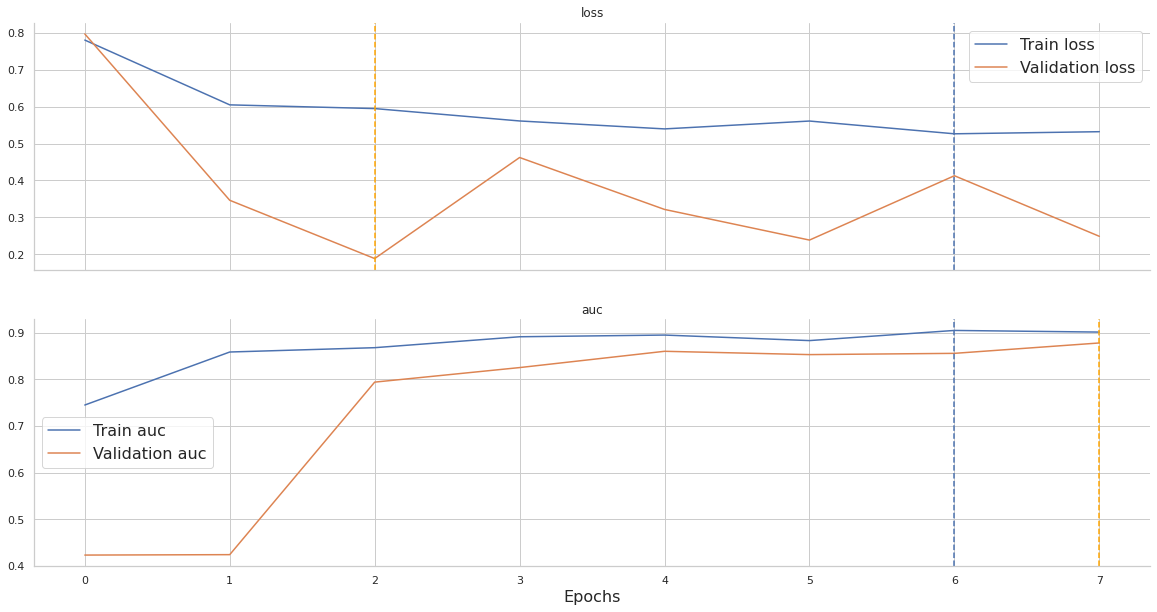

Fold: 1


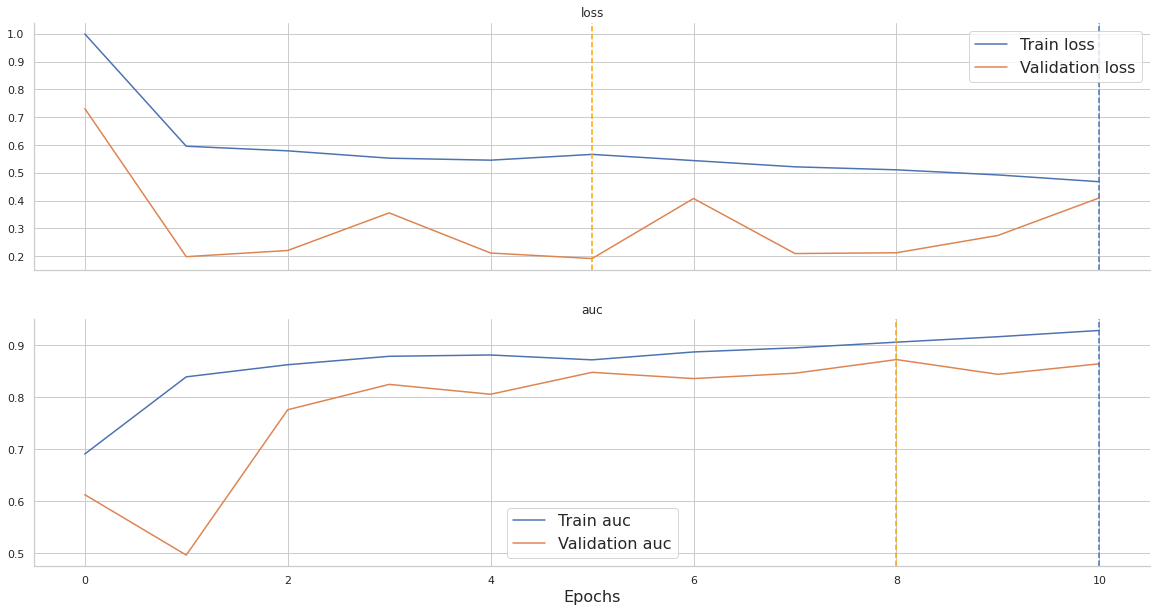

Fold: 2


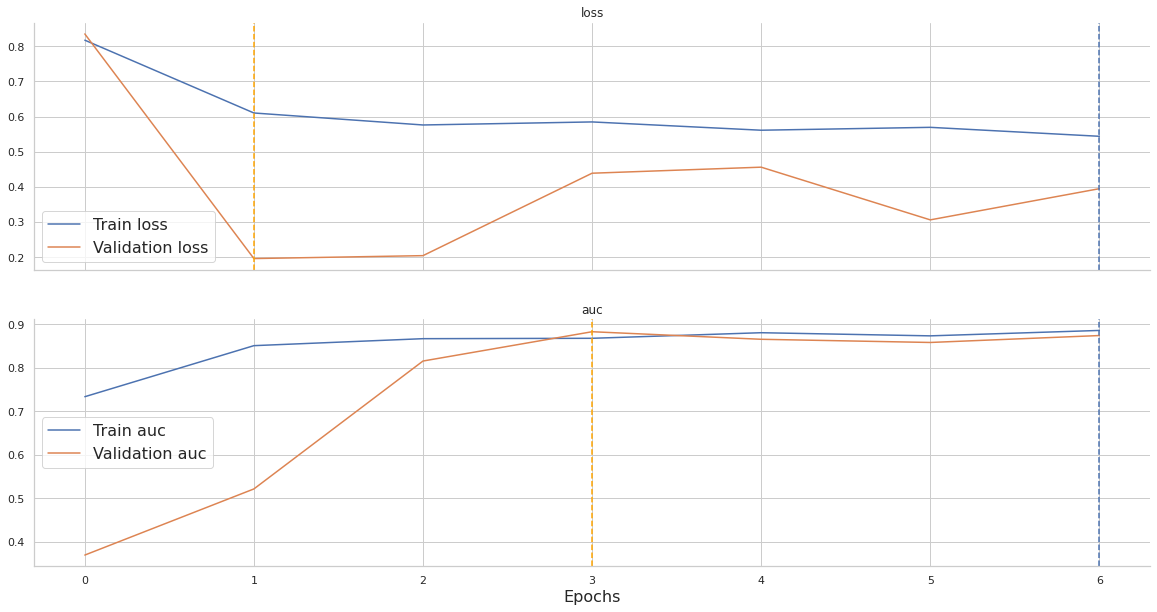

In [10]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

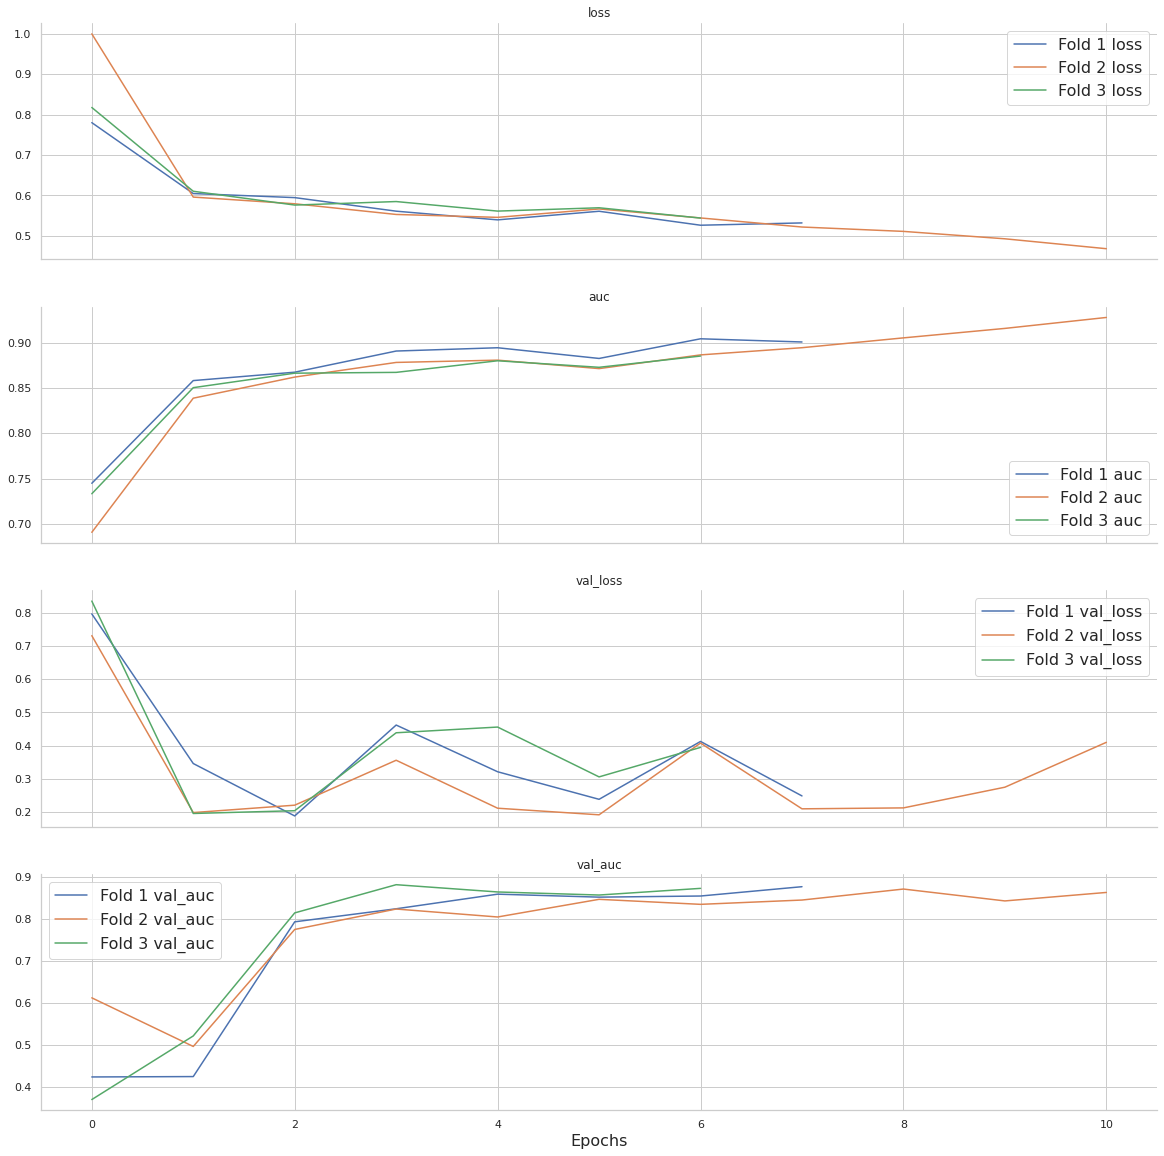

In [11]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [12]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.768815,0.720954,0.047861,0.843090,0.793303,0.889259,0.847698,0.574096,0.521860
Accuracy,0.980725,0.980158,0.000567,0.978792,0.980283,0.980949,0.977960,0.982434,0.982231
Precision,0.177440,0.108730,0.068709,0.253968,0.183333,0.278351,0.142857,0.000000,0.000000
Recall,0.051311,0.029803,0.021508,0.084881,0.053140,0.069054,0.036269,0.000000,0.000000
F1-score,0.079297,0.046749,0.032548,0.127237,0.082397,0.110656,0.057851,0.000000,0.000000
Support,389.333333,194.666667,194.666667,377.000000,207.000000,391.000000,193.000000,400.000000,184.000000


# Model evaluation by Subset

In [13]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.768815,0.720954,0.047861,0.843090,0.793303,0.889259,0.847698,0.574096,0.521860
male,0.777429,0.734856,0.042573,0.847903,0.793453,0.887468,0.849699,0.596916,0.561415
female,0.761274,0.700436,0.060838,0.830546,0.785990,0.890408,0.836479,0.562869,0.478838
head/neck,0.712786,0.641027,0.071759,0.711632,0.756051,0.826509,0.720508,0.600218,0.446524
upper extremity,0.764070,0.730592,0.033478,0.833798,0.814921,0.883213,0.858781,0.575200,0.518074
lower extremity,0.746842,0.695755,0.051087,0.798162,0.705888,0.887135,0.827344,0.555228,0.554033
torso,0.791434,0.754105,0.037329,0.890801,0.845491,0.896397,0.869867,0.587105,0.546958
0 <= age < 26,0.762954,0.730856,0.032099,0.867717,0.798529,0.831644,0.815851,0.589503,0.578187
26 <= age < 40,0.737253,0.678422,0.058831,0.808326,0.741271,0.879219,0.850404,0.524213,0.443591


# Confusion matrix

Fold: 1


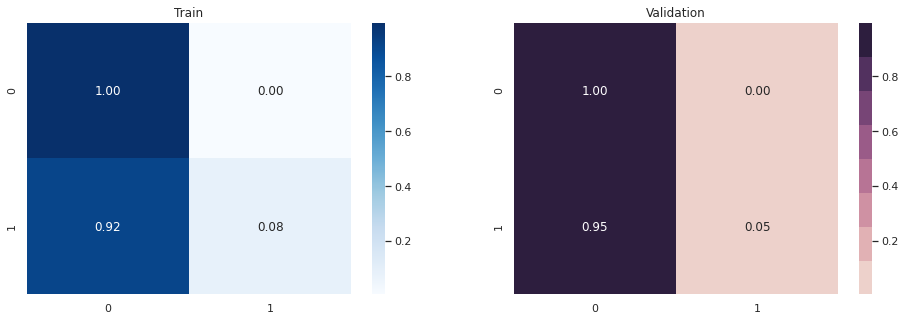

Fold: 2


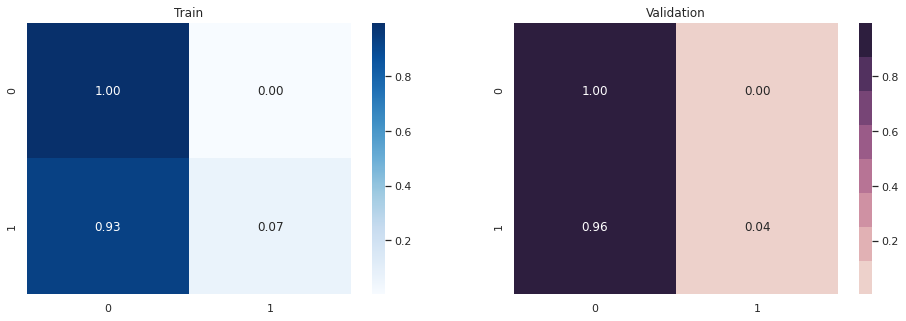

Fold: 3


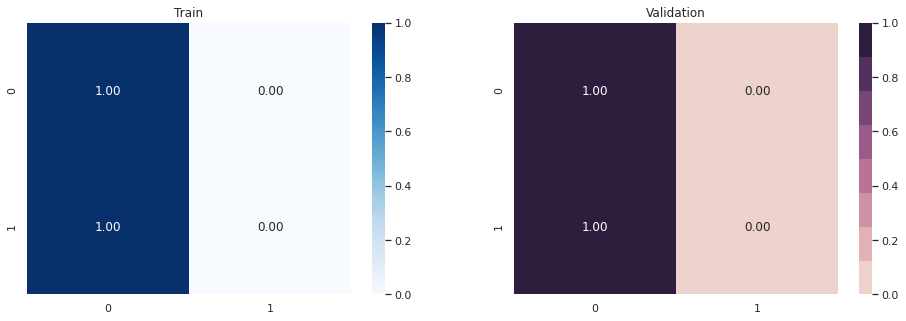

In [14]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [15]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred >= .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.046590,0.026050,0.077348,0.036372
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.037490,0.025712,0.058650,0.028107
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.023710,0.035929,0.022773,0.012430
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.064313,0.006894,0.177347,0.008698
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.064003,0.034307,0.044487,0.113216
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.029599,0.030184,0.053728,0.004885
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.052458,0.016691,0.069738,0.070944
7,ISIC_0075663,female,35.0,torso,unknown,0,0.145755,0.184196,0.181518,0.071550
8,ISIC_0075914,male,30.0,torso,unknown,0,0.050916,0.040308,0.051679,0.060761
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.031635,0.008145,0.046926,0.039835


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.086879,0.037894,0.107667,0.115075
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.138002,0.099785,0.255674,0.058546
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.064382,0.036109,0.074199,0.082837
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.125756,0.103944,0.118239,0.155085
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.055995,0.025073,0.070556,0.072355
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.094304,0.133617,0.102735,0.046559
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.221061,0.425432,0.168088,0.069662
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.104265,0.095065,0.140565,0.077164
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.215163,0.482055,0.134822,0.028612
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.133268,0.065129,0.315461,0.019212


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
801,ISIC_0343061,female,70.0,torso,nevus,0,0.517062,0.618279,0.852340,0.080567
980,ISIC_0401250,male,60.0,lower extremity,unknown,0,0.516017,0.644170,0.866884,0.036998
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.560653,0.767389,0.853015,0.061555
3714,ISIC_1219894,female,75.0,lower extremity,unknown,0,0.505848,0.626269,0.816694,0.074581
7495,ISIC_2341875,male,45.0,torso,melanoma,1,0.513204,0.756693,0.777409,0.005509
8881,ISIC_2761440,male,80.0,torso,unknown,0,0.533402,0.722383,0.832711,0.045112
8927,ISIC_2776906,male,70.0,torso,melanoma,1,0.574237,0.838130,0.797299,0.087283
14005,ISIC_4298309,female,35.0,upper extremity,unknown,0,0.533048,0.737161,0.802190,0.059792
15205,ISIC_4654808,male,80.0,torso,unknown,0,0.535649,0.804637,0.728221,0.074089
16214,ISIC_4960784,female,75.0,upper extremity,melanoma,1,0.589134,0.819633,0.862678,0.085092


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 18


# Make predictions

In [16]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5


In [17]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    print(model_path)
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target >= .5').head(10))

Test predictions 10|10972
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.020213
1,ISIC_0052349,male,40.0,lower extremity,0.026918
2,ISIC_0058510,female,55.0,torso,0.066830
3,ISIC_0073313,female,50.0,torso,0.042163
4,ISIC_0073502,female,45.0,lower extremity,0.060321
5,ISIC_0074618,male,50.0,lower extremity,0.098223
6,ISIC_0076801,male,45.0,upper extremity,0.060275
7,ISIC_0077586,male,50.0,lower extremity,0.063582
8,ISIC_0082004,female,45.0,torso,0.058648
9,ISIC_0082785,male,65.0,lower extremity,0.123569


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
596,ISIC_0637104,female,80.0,torso,0.570870
1334,ISIC_1294368,female,35.0,torso,0.507141
1827,ISIC_1727295,female,70.0,torso,0.586343
2168,ISIC_2052123,female,70.0,torso,0.536420
2293,ISIC_2170268,female,80.0,upper extremity,0.571717
4332,ISIC_4000026,male,90.0,torso,0.539094
5078,ISIC_4655939,female,80.0,lower extremity,0.546144
5412,ISIC_4965292,female,80.0,upper extremity,0.528220
7865,ISIC_7132534,female,45.0,torso,0.552182
8745,ISIC_7940557,female,80.0,lower extremity,0.510450


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.020213
1,ISIC_0052349,0.026918
2,ISIC_0058510,0.066830
3,ISIC_0073313,0.042163
4,ISIC_0073502,0.060321
5,ISIC_0074618,0.098223
6,ISIC_0076801,0.060275
7,ISIC_0077586,0.063582
8,ISIC_0082004,0.058648
9,ISIC_0082785,0.123569


,target
count,10982.000000
mean,0.075087
std,0.053908
min,0.007102
25%,0.039807
50%,0.061105
75%,0.093367
max,0.586343
